# Applying MYCN Signature Learned in TARGET data to Cell Lines

**Gregory Way, 2019**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../8.gtex-interpret")
from scripts.utils import load_weight_matrix, apply_signature

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline

## 1. Load NBL Processed Dataset

In [4]:
file = os.path.join('data', 'nbl_celllines_processed_matrix.tsv.gz')
nbl_df = pd.read_table(file, index_col=0)

print(nbl_df.shape)
nbl_df.head(2)

(40, 18628)


,1,2,9,12,13,14,15,16,18,19,...,105375787,106707243,106821730,106865373,107080638,107080644,107181291,107984155,107984923,107987479
CHP134,0.496142,0.000000,0.031914,0.0,0.000000,0.335754,1.000000,0.527104,0.123020,0.101682,...,0.0,0.202001,0.350250,0.0,0.359538,0.0,0.0,0.0,0.398515,0.0
CHP212,0.130269,0.077607,0.384543,0.0,0.047631,0.483361,0.011138,0.680574,0.002162,0.136316,...,0.0,0.030310,0.673424,0.0,0.086474,0.0,0.0,0.0,0.556493,0.0


## 2. Apply Signature Learned by TARGET data

In [5]:
# Identify the top performing feature
file = os.path.join("results", "nbl_mycn_separation_target_t_test.tsv")
target_full_results_df = pd.read_table(file).head(5)
target_full_results_df

,t_stat,t_p,algorithm,feature_num,z_dim,signal,seed,neg_log_p
0,-13.979762,3.886965e-25,dae,88,100,signal,451283,24.410389
1,-12.759128,4.343456e-25,vae,80,150,signal,165158,24.362165
2,-12.770938,4.808223e-24,vae,55,125,signal,451283,23.318015
3,-11.964911,5.395353e-23,vae,148,150,signal,486191,22.267980
4,-12.538324,5.796144e-23,vae,9,25,signal,451283,22.236861


In [6]:
top_seed = str(target_full_results_df.seed.values[0])
top_k = int(target_full_results_df.z_dim.values[0])
top_feature = "{}_{}".format(target_full_results_df.algorithm.values[0],
                             target_full_results_df.feature_num.values[0])

print(top_seed, top_k, top_feature)

451283 100 dae_88


In [7]:
weight_df = load_weight_matrix(dataset='TARGET',
                               z_dim=top_k,
                               seed=top_seed)
weight_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,dae_90,dae_91,dae_92,dae_93,dae_94,dae_95,dae_96,dae_97,dae_98,dae_99
gene_id,,,,,,,,,,,,,,,,,,,,,
8337,-0.004849,-0.023897,-0.016095,-0.018362,0.034889,0.008711,0.005634,-0.008216,-0.025271,0.026315,...,-0.005998,-0.034176,0.008720,0.010468,0.097453,-0.066156,-0.037717,-0.023922,-0.026102,-0.062553
56849,-0.026866,0.001740,-0.009147,-0.009055,-0.008393,-0.010301,0.009526,-0.006650,0.000642,0.013793,...,-0.042937,0.060258,-0.072732,-0.117177,0.061172,-0.045312,-0.021099,-0.070007,-0.231790,-0.059933
5999,-0.025851,-0.000609,-0.004601,-0.013925,-0.003599,-0.007169,0.008380,-0.000327,-0.000511,0.008288,...,-0.007138,-0.022248,-0.048239,-0.129829,0.031669,-0.055710,-0.012849,-0.053054,-0.190942,-0.049923
6192,0.000613,0.000113,-0.002125,-0.006721,0.024305,-0.000472,-0.010771,-0.000680,-0.005298,-0.017055,...,-0.022113,-0.015699,0.022903,-0.014464,0.092645,-0.031979,0.023671,0.030227,0.006775,-0.034412
3880,-0.021859,0.000071,-0.008843,-0.001078,-0.020019,-0.002469,0.016229,-0.005949,0.009196,0.020103,...,-0.054684,-0.013030,0.018278,-0.113477,0.011114,-0.110935,0.017645,-0.061934,-0.140107,-0.006206


In [8]:
result_mycn_df, nbl_missing_genes = (
    apply_signature(weight_df=weight_df,
                    other_df=nbl_df,
                    feature=top_feature,
                    align=True)
)

use_genes = weight_df.shape[0] - len(nbl_missing_genes)
print('{} ({}%) of genes are used'.format(use_genes, use_genes / weight_df.shape[0] * 100 ))

7653 (95.6625%) of genes are used


In [9]:
result_mycn_df.head()

,dae_88
CHP134,0.605411
CHP212,-4.847081
COGN415,1.099717
COGN440,1.527359
COGN453,1.137930


## 3. Align with Phenotype Data

In [10]:
file = os.path.join("download", "nbl_cellline_phenotype.txt")
pheno_df = pd.read_table(file)

pheno_df.head()

,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22...,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT


In [11]:
merged_df = (
    result_mycn_df
    .merge(pheno_df,
           left_index=True,
           right_on="Cell Line")
    .reset_index(drop=True)
)

file = os.path.join("results", "mycn_nbl_scores.tsv")
merged_df.to_csv(file, sep='\t')

merged_df.head()

,dae_88,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,0.605411,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22...,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,-4.847081,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,1.099717,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,1.527359,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,1.137930,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT


In [12]:
merged_df['MYCN status'].value_counts()

Amplified        20
Non-amplified    10
Name: MYCN status, dtype: int64

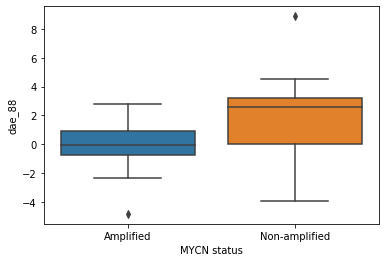

In [13]:
sns.boxplot(x="MYCN status", y=top_feature, data=merged_df);

In [14]:
# Perform t-test on the result
amplified_scores = merged_df.loc[merged_df['MYCN status'] == "Amplified", top_feature]
notamplified_scores = merged_df.loc[merged_df['MYCN status'] != "Amplified", top_feature]

ttest_ind(amplified_scores, notamplified_scores, equal_var=False)

Ttest_indResult(statistic=-1.8502039929232892, pvalue=0.09085291671848125)